# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from scipy.io import loadmat
import pandas as pd
import neurokit2 as nk
import numpy as np

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Display Modalities

In [2]:
path = "D:\Studium\Master\Masterarbeit\datasets\INTENSE\\"
subject = "1_zusammen"

In [3]:
data = loadmat(path+subject+".mat")
biodata = {"cor": data["CORbt"].flatten(),
            "zyg": data["ZYGbt"].flatten(),
            "eda": data["SCL_filt"].flatten(),
            "ecg": data["ECG"].flatten()}

In [4]:
sampling_rate=512
timestamps = data["morphin_timestamps"].flatten()
start = timestamps[0]
end = timestamps[0]+10*sampling_rate

#no pain
delta = 5*60*sampling_rate

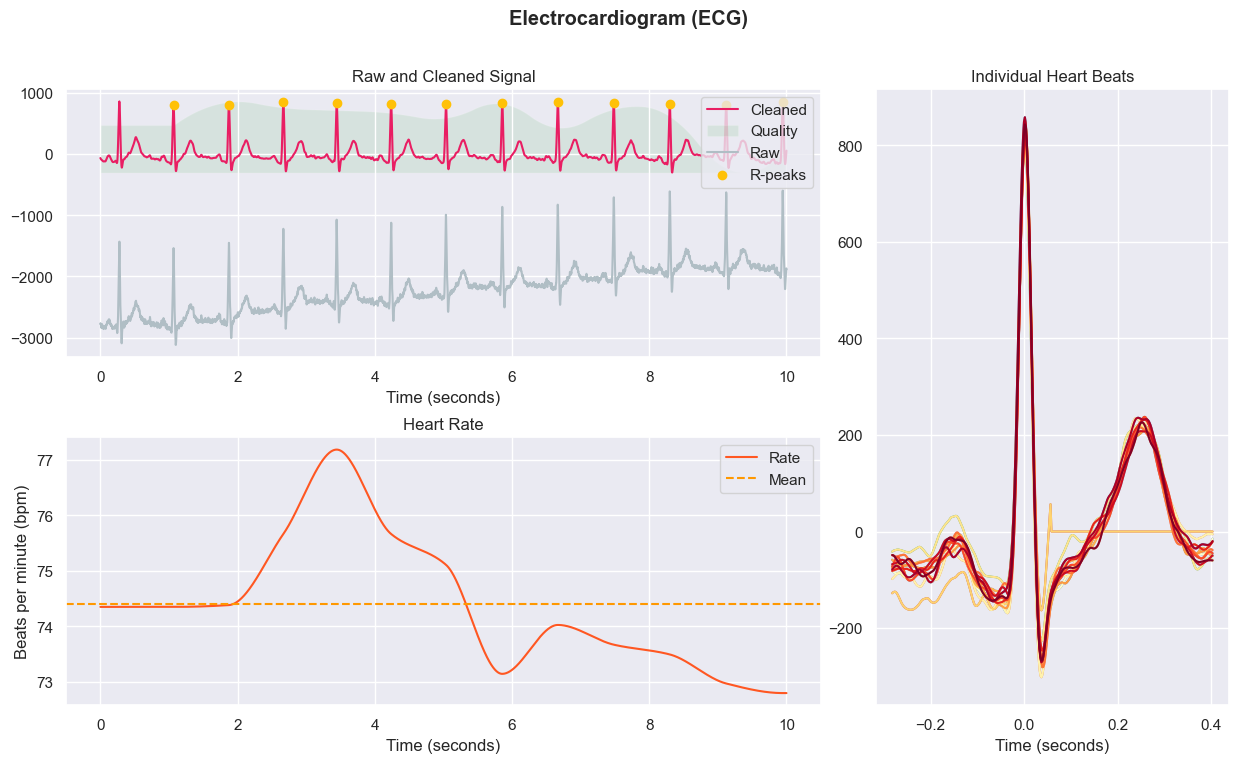

In [5]:
ecg_signals, _ = nk.ecg_process(biodata["ecg"][start:end], sampling_rate=sampling_rate)
nk.ecg_plot(ecg_signals, sampling_rate=sampling_rate, show_type='default')
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(15)

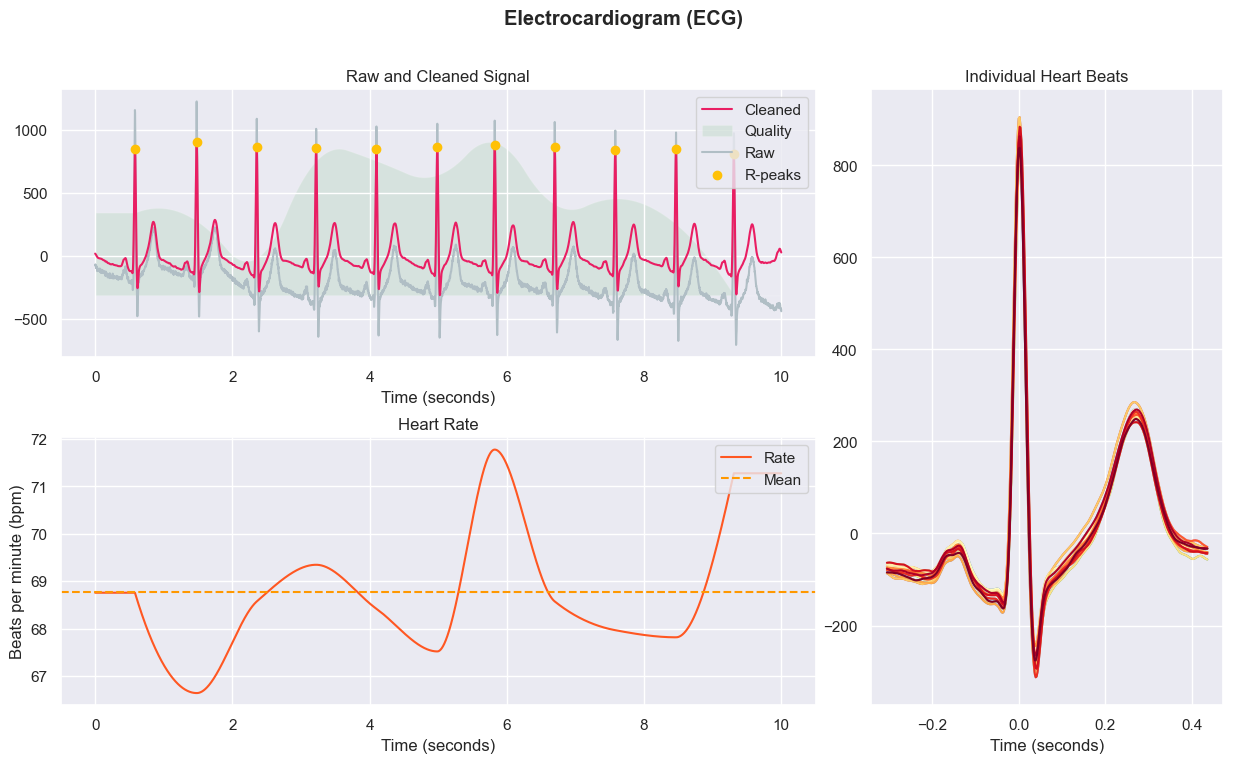

In [12]:
ecg_signals, _ = nk.ecg_process(biodata["ecg"][start+delta:end+delta], sampling_rate=sampling_rate)
nk.ecg_plot(ecg_signals, sampling_rate=sampling_rate, show_type='default')
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(15)

In [21]:
epochs = nk.epochs_create(data=ecg_signals, events = [0], sampling_rate = 512, epochs_start = 0, epochs_end = 5)

In [ ]:
12

In [28]:
nk.ecg_analyze(epochs).drop(["Label", "ECG_Phase_Atrial", "ECG_Phase_Ventricular", "ECG_Quality_Mean", "Event_Onset"], axis=1).keys()

Index(['ECG_Rate_Baseline', 'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean',
       'ECG_Rate_SD', 'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time',
       'ECG_Rate_Trend_Linear', 'ECG_Rate_Trend_Quadratic',
       'ECG_Rate_Trend_R2', 'ECG_Phase_Completion_Atrial',
       'ECG_Phase_Completion_Ventricular'],
      dtype='object')

In [25]:
nk.ecg_analyze(epochs).drop(["Label", "ECG_Phase_Atrial", "ECG_Phase_Ventricular", "ECG_Quality_Mean"], axis=1)["Event_Onset"]

1    0
Name: Event_Onset, dtype: int64

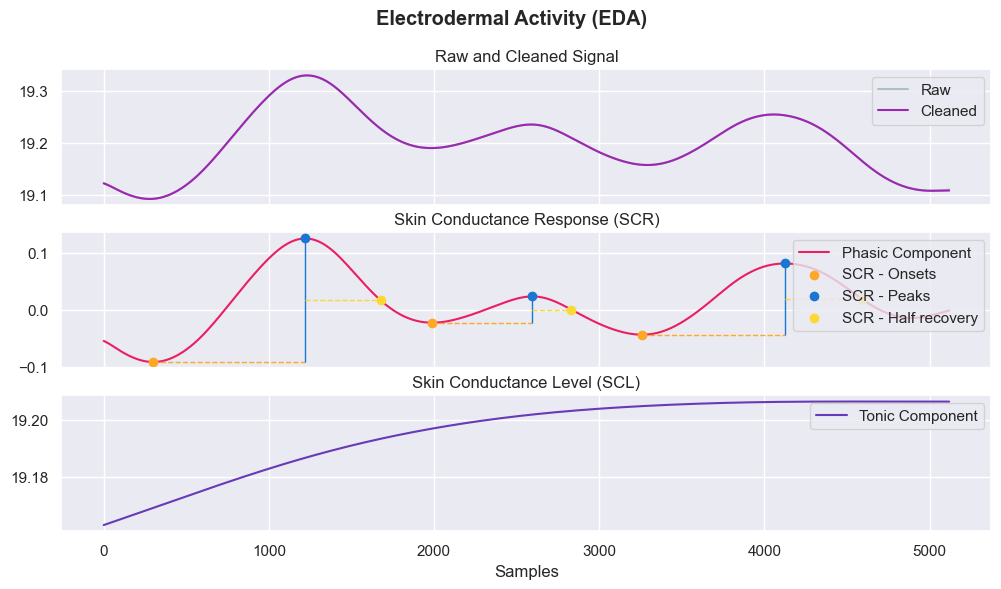

In [6]:
eda_signals, info = nk.eda_process(biodata["eda"][start:end], sampling_rate=sampling_rate)
nk.eda_plot(eda_signals)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(12)

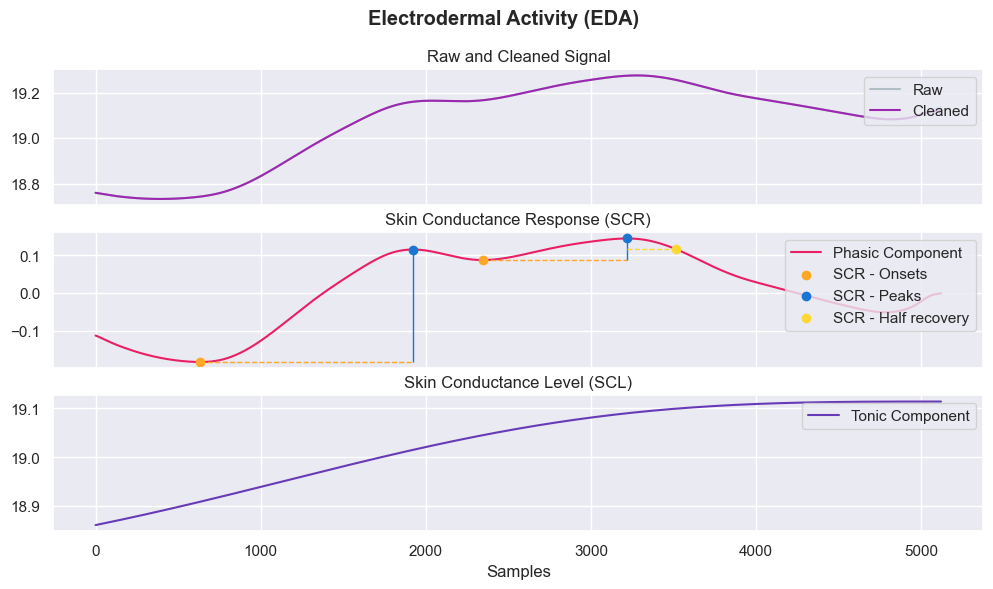

In [18]:
eda_signals, info = nk.eda_process(biodata["eda"][start+delta:end+delta], sampling_rate=sampling_rate)
nk.eda_plot(eda_signals)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(12)

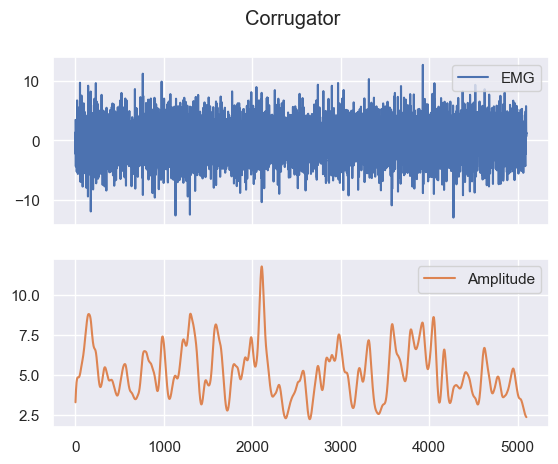

In [9]:
cleaned = nk.emg_clean(biodata["cor"][start:end], sampling_rate=sampling_rate)
amplitude = nk.emg_amplitude(cleaned)
ax1 = pd.DataFrame({"EMG": biodata["cor"][start+20:end], "Amplitude": amplitude[20:]}).plot(subplots=True, title="Corrugator")

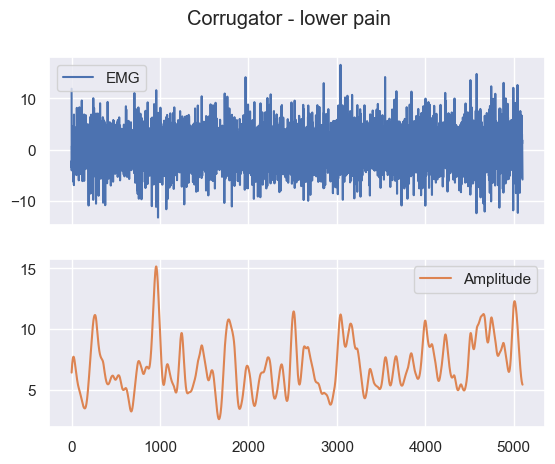

In [15]:
cleaned = nk.emg_clean(biodata["cor"][start+delta:end+delta], sampling_rate=sampling_rate)
amplitude = nk.emg_amplitude(cleaned)
ax1 = pd.DataFrame({"EMG": biodata["cor"][start+20+delta:end+delta], "Amplitude": amplitude[20:]}).plot(subplots=True, title="Corrugator - lower pain")

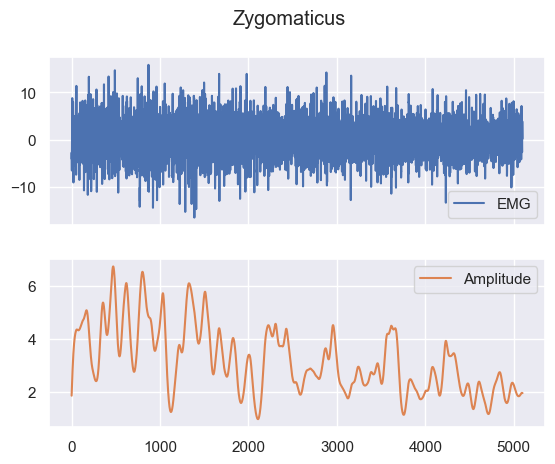

In [10]:
cleaned = nk.emg_clean(biodata["zyg"][start:end], sampling_rate=sampling_rate)
amplitude = nk.emg_amplitude(cleaned)
ax2 = pd.DataFrame({"EMG": biodata["zyg"][start+20:end], "Amplitude": amplitude[20:]}).plot(subplots=True, title="Zygomaticus")

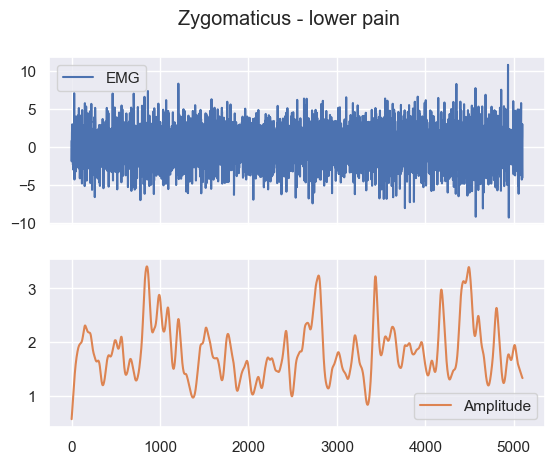

In [16]:
#no pain
delta = 5*60*sampling_rate
cleaned = nk.emg_clean(biodata["zyg"][start+delta:end+delta], sampling_rate=sampling_rate)
amplitude = nk.emg_amplitude(cleaned)
ax2 = pd.DataFrame({"EMG": biodata["zyg"][start+20+delta:end+delta], "Amplitude": amplitude[20:]}).plot(subplots=True, title="Zygomaticus - lower pain")

# Display Dataset

In [2]:
path_dataset = "D:\Workspace\workspace_masterarbeit\PainLevelShiftDetection\FeatureGeneration\dataset_processed\INTENSE\\normalized_subjects.pkl"
data = pd.read_pickle(path_dataset)

In [10]:
eda = [key for key in list(data.keys()) if key.lower().startswith("eda")]
ecg = [key for key in list(data.keys()) if key.lower().startswith("ecg")]
zyg = [key for key in list(data.keys()) if key.lower().startswith("zyg")]
cor = [key for key in list(data.keys()) if key.lower().startswith("cor")]

print("eda:", len(eda))
print("ecg:", len(ecg))
print("zyg:", len(zyg))
print("cor:", len(cor))
print("all:", len(ecg)+len(eda)+len(cor)+len(zyg))

eda: 61
ecg: 52
zyg: 47
cor: 47
all: 207


In [3]:
print("dataset length:", len(data))
print("pain samples:", data.groupby(['pain'])['pain'].count()[1])
print("no pain samples:", data.groupby(['pain'])['pain'].count()[0])
print("number subjects:", data["subject"].nunique())
print("samples per subject (mean):", round(data.groupby(['subject'])['subject'].count().mean(), 2))

dataset length: 620
pain samples: 310
no pain samples: 310
number subjects: 24
samples per subject (mean): 25.83


# Outlier Detection

##### pain

In [5]:
data_pain = data[data["pain"]==1]
data_pain = data_pain.drop(["pain", "subject"], axis=1)
clf_pain = IsolationForest(random_state=0).fit(data_pain)
pred_pain = clf_pain.predict(data_pain)
print("percentage of none outliers:", round(100*sum(pred_pain>0)/len(data_pain), 3))

percentage of none outliers: 92.581


##### no pain

In [6]:
data_nopain = data[data["pain"]==0]
data_nopain = data_nopain.drop(["pain", "subject"], axis=1)
clf_nopain = IsolationForest(random_state=0).fit(data_nopain)
pred_nopain = clf_nopain.predict(data_nopain)
print("percentage of none outliers:", round(100*sum(pred_nopain>0)/len(data_nopain), 3))

percentage of none outliers: 93.548
